# Cutting Stock – Time Complexity: Standard ILP vs Column Generation

In this notebook we:

1. Implement the **standard ILP** formulation in PuLP.
2. Implement a **column generation (pattern-based)** formulation (LP relaxation).
3. Generate problem instances of increasing size.
4. Measure runtimes of both approaches and compare.


In [19]:
# %% [markdown]
# ## 0. Imports and basic setup

# %%
import time
import random
import math

import pulp as pl
import matplotlib.pyplot as plt


## 1. Instance generator

We generate synthetic cutting stock instances by choosing:
- A roll length $L$
- A number of item types $m$
- Random item lengths
- Demands that scale with a parameter


In [20]:
# %% [markdown]
# ## 1. Instance generator

# %%
def generate_instance(L=50, m=5, demand_scale=4, seed=None):
    """
    Generate a random cutting stock instance.
    
    Returns:
        L (int): roll length
        item_lengths (dict): i -> l_i
        demands (dict): i -> b_i
    """
    if seed is not None:
        random.seed(seed)
    
    item_lengths = {}
    demands = {}
    
    # Generate random lengths between L/10 and L/3 (to avoid trivial extremes)
    for i in range(1, m + 1):
        length = random.randint(L // 10, L // 3)
        item_lengths[i] = length
        
        # Demand scaled by demand_scale
        demand = random.randint(3,10) * demand_scale
        demands[i] = demand
    
    return L, item_lengths, demands


# quick sanity check
L_test, item_lengths_test, demands_test = generate_instance(L=70, m=2, demand_scale=2, seed=0)
print("L =", L_test)
print("item_lengths =", item_lengths_test)
print("demands =", demands_test)


L = 70
item_lengths = {1: 19, 2: 8}
demands = {1: 18, 2: 14}


In [21]:
# import random

# def estimate_pattern_upper_bound(L, item_lengths):
#     """
#     Crude upper bound on the number of possible patterns.

#     For each item i, x_i can be between 0 and floor(L / l_i).
#     So total combinations <= ∏_i (floor(L / l_i) + 1) - 1 (minus the all-zero).
#     This overcounts because many combinations will exceed L, but it's
#     a cheap and safe upper bound.
#     """
#     upper = 1
#     for l in item_lengths.values():
#         upper *= (L // l) + 1
#     return upper - 1


# def generate_instance(
#     L=50,
#     m=5,
#     demand_scale=4,
#     seed=None,
#     max_pattern_upper_bound=None,
#     max_tries=100,
#     verbose=True,
#     length_min_frac=0.1,
#     length_max_frac=0.3,
#     return_pattern_info=True,
# ):
#     """
#     Generate a random cutting stock instance, with control over how
#     'combinatorially explosive' it can be.

#     Args:
#         L: roll length
#         m: number of item types
#         demand_scale: multiplier for demands
#         seed: RNG seed
#         max_pattern_upper_bound: if not None, reject instances whose
#             estimated pattern upper bound exceeds this value.
#         max_tries: how many times to resample before giving up.
#         verbose: if True, print info about pattern bound / attempts.
#         length_min_frac: min item length as fraction of L (e.g. 0.1 → L/10)
#         length_max_frac: max item length as fraction of L (e.g. 0.3 → L/3)
#         return_pattern_info: if True, returns pattern_upper_bound as 4th output.

#     Returns:
#         If return_pattern_info:
#             L, item_lengths (dict i → l_i), demands (dict i → b_i), pattern_upper_bound
#         else:
#             L, item_lengths, demands
#     """
#     if seed is not None:
#         random.seed(seed)

#     min_len = max(1, int(L * length_min_frac))
#     max_len = max(min_len + 1, int(L * length_max_frac))

#     last_pattern_ub = None

#     for attempt in range(1, max_tries + 1):
#         item_lengths = {}
#         demands = {}

#         # Generate random lengths
#         for i in range(1, m + 1):
#             length = random.randint(min_len, max_len)
#             item_lengths[i] = length

#             # Demand scaled by demand_scale
#             demand = random.randint(3, 7) * demand_scale
#             demands[i] = demand

#         # Estimate pattern upper bound for this instance
#         pattern_ub = estimate_pattern_upper_bound(L, item_lengths)
#         last_pattern_ub = pattern_ub

#         if verbose:
#             print(
#                 f"[Attempt {attempt}] Estimated pattern upper bound ≈ {pattern_ub} "
#                 f"(min_len={min_len}, max_len={max_len})"
#             )

#         # Accept or reject based on threshold
#         if (max_pattern_upper_bound is None) or (pattern_ub <= max_pattern_upper_bound):
#             if verbose:
#                 print(f"→ Instance accepted on attempt {attempt}.")
#             if return_pattern_info:
#                 return L, item_lengths, demands, pattern_ub
#             else:
#                 return L, item_lengths, demands

#     # If we get here, we failed to find a 'small enough' instance
#     if verbose:
#         print(
#             f"WARNING: could not find instance with pattern upper bound ≤ "
#             f"{max_pattern_upper_bound} in {max_tries} tries. "
#             f"Last estimated bound was {last_pattern_ub}."
#         )

#     if return_pattern_info:
#         return L, item_lengths, demands, last_pattern_ub
#     else:
#         return L, item_lengths, demands


In [22]:
# L, item_lengths, demands, pattern_ub = generate_instance(
#     L=50,
#     m=5,
#     demand_scale=4,
#     seed=123,
#     max_pattern_upper_bound=10_000,
#     verbose=True
# )

# print("Final instance:")
# print("  Lengths:", item_lengths)
# print("  Demands:", demands)
# print("  Estimated #patterns (upper bound):", pattern_ub)


## 2. Standard ILP formulation (roll-based)

We use:

- Variables:
  - $y_n$: binary, 1 if roll $n$ is used
  - $x_i^n$: integer, number of times item $i$ is cut on roll $n$
- Objective: minimize $\sum_n y_n$
- Constraints:
  - Demand: $\sum_n x_i^n \ge b_i$
  - Capacity: $\sum_i l_i x_i^n \le L y_n$


In [23]:
# %% [markdown]
# ## 2. Standard ILP solver (roll-based)

# %%
def solve_standard_ilp(L, item_lengths, demands, time_limit=None, msg=False):
    """
    Solve the cutting stock problem with the standard roll-based ILP.
    
    Returns:
        status (str)
        objective_value (float)
        runtime (float)
    """
    items = list(item_lengths.keys())
    
    # Upper bound on number of rolls: sum of demands
    N_max = sum(demands.values())
    rolls = list(range(N_max))
    
    prob = pl.LpProblem("CuttingStock_ILP", pl.LpMinimize)
    
    # Variables
    y = pl.LpVariable.dicts("y", rolls, lowBound=0, upBound=1, cat=pl.LpBinary)
    x = pl.LpVariable.dicts("x", (items, rolls), lowBound=0, cat=pl.LpInteger)
    
    # Objective
    prob += pl.lpSum(y[n] for n in rolls)
    
    # Demand constraints
    for i in items:
        prob += pl.lpSum(x[i][n] for n in rolls) >= demands[i], f"Demand_{i}"
    
    # Capacity constraints
    for n in rolls:
        prob += pl.lpSum(item_lengths[i] * x[i][n] for i in items) <= L * y[n], f"Cap_{n}"
    
    # Solve
    solver = pl.PULP_CBC_CMD(msg=msg, timeLimit=time_limit)
    
    start = time.perf_counter()
    status_code = prob.solve(solver)
    end = time.perf_counter()
    
    status = pl.LpStatus[status_code]
    obj = pl.value(prob.objective)
    runtime = end - start
    
    return status, obj, runtime


## 3. Column Generation – Pattern-based LP relaxation

We:

1. Start with simple patterns (one item per rod, repeated as many times as fits).
2. Define a **master LP**:

   - Variables: $x_p \ge 0$ (continuous, number of times pattern $p$ is used)  
   - Minimize $\sum_p x_p$  
   - Demand: $\sum_p a_{ip} x_p \ge b_i$

3. Get duals for demand constraints and solve the **pricing problem**:

   - Knapsack: $\max \sum_i \pi_i z_i$  
     subject to $\sum_i l_i z_i \le L$, $z_i \in \mathbb{Z}_+$  

4. If reduced cost $1 - \sum_i \pi_i z_i < 0$, add pattern and repeat.
5. Stop when no improving pattern exists.


In [24]:
# %% [markdown]
# ## 3. Column generation (LP relaxation, pattern-based) — FIXED

# %%
def build_initial_patterns(L, item_lengths):
    """
    Build a simple initial set of patterns:
    For each item i, create a pattern that uses only item i, as many times as fits.
    
    Returns:
        patterns: list of dicts {i: count}
    """
    patterns = []
    for i, li in item_lengths.items():
        count = L // li
        if count > 0:
            patterns.append({i: count})
    return patterns


def solve_master_lp(L, item_lengths, demands, patterns, msg=False):
    """
    Solve the restricted master LP for given patterns.
    
    patterns: list of dicts, each dict maps item i -> count in that pattern.
    
    Returns:
        prob: the PuLP problem object
        x_vars: dict p -> variable
        duals: dict i -> dual value of demand constraint i
        objective_value: float
    """
    items = list(item_lengths.keys())
    P = list(range(len(patterns)))  # pattern indices
    
    prob = pl.LpProblem("CuttingStock_MasterLP", pl.LpMinimize)
    
    # Variables: x_p >= 0 (continuous)
    x = pl.LpVariable.dicts("x", P, lowBound=0, cat=pl.LpContinuous)
    
    # Objective: minimize sum_p x_p
    prob += pl.lpSum(x[p] for p in P)
    
    # Demand constraints
    demand_constraint_names = {}
    for i in items:
        lhs = pl.lpSum(patterns[p].get(i, 0) * x[p] for p in P)
        name = f"Demand_{i}"
        prob += (lhs >= demands[i], name)
        demand_constraint_names[i] = name
    
    # Solve LP (CBC gives duals)
    solver = pl.PULP_CBC_CMD(msg=msg)
    prob.solve(solver)
    
    # Get duals from prob.constraints[name].pi
    duals = {}
    for i in items:
        cname = demand_constraint_names[i]
        duals[i] = prob.constraints[cname].pi
    
    obj = pl.value(prob.objective)
    
    return prob, x, duals, obj


def solve_pricing_problem(L, item_lengths, duals, msg=False):
    """
    Pricing problem (integer knapsack):
    max sum_i duals[i] * z_i
    s.t. sum_i l_i * z_i <= L
         z_i >= 0 integer
    
    Returns:
        best_pattern: dict i -> z_i
        best_value: objective value (sum duals[i] * z_i)
    """
    items = list(item_lengths.keys())
    
    prob = pl.LpProblem("Pricing", pl.LpMaximize)
    
    z = pl.LpVariable.dicts("z", items, lowBound=0, cat=pl.LpInteger)
    
    # Objective
    prob += pl.lpSum(duals[i] * z[i] for i in items)
    
    # Capacity
    prob += pl.lpSum(item_lengths[i] * z[i] for i in items) <= L
    
    solver = pl.PULP_CBC_CMD(msg=msg)
    prob.solve(solver)
    
    best_value = pl.value(prob.objective)
    
    # Extract pattern
    pattern = {}
    for i in items:
        val = pl.value(z[i])
        if val is not None:
            val = int(round(val))
            if val > 0:
                pattern[i] = val
    
    return pattern, best_value


def solve_column_generation(L, item_lengths, demands, max_iter=50, tol=1e-6, msg=False):
    """
    Column generation algorithm for the LP relaxation of cutting stock.
    
    Returns:
        patterns: list of patterns at the end
        objective_value: float
        runtime: float
        iterations: int
    """
    # Build initial patterns
    patterns = build_initial_patterns(L, item_lengths)
    
    start = time.perf_counter()
    iterations = 0
    
    while True:
        iterations += 1
        if iterations > max_iter:
            break
        
        # Step 1: solve master LP
        master, x_vars, duals, obj = solve_master_lp(L, item_lengths, demands, patterns, msg=msg)
        
        # Step 2: solve pricing problem
        new_pattern, best_value = solve_pricing_problem(L, item_lengths, duals, msg=msg)
        
        # Reduced cost = 1 - sum_i duals[i] * z_i
        reduced_cost = 1.0 - (best_value if best_value is not None else 0.0)
        
        if msg:
            print(f"Iter {iterations}: obj={obj:.4f}, pricing value={best_value:.4f}, rc={reduced_cost:.4f}")
        
        # If no negative reduced cost, stop
        if reduced_cost >= -tol or not new_pattern:
            break
        
        # Otherwise, add new pattern and continue
        patterns.append(new_pattern)
    
    end = time.perf_counter()
    runtime = end - start
    
    return patterns, obj, runtime, iterations


## 4. Sanity check on a small instance

We compare:
- Standard ILP (integer, roll-based).
- Column generation LP relaxation (pattern-based).

We do not expect the same objective (LP relaxation is a lower bound), but they should be close.


In [25]:
# %% [markdown]
# ## 4. Sanity check

# %%
L_demo, item_lengths_demo, demands_demo = generate_instance(L=70, m=3, demand_scale=2, seed=1)

print("Demo instance")
print("L =", L_demo)
print("item_lengths =", item_lengths_demo)
print("demands =", demands_demo)

# Standard ILP
status_ilp, obj_ilp, t_ilp = solve_standard_ilp(L_demo, item_lengths_demo, demands_demo, msg=False)
print("\nStandard ILP:")
print("  Status:", status_ilp)
print("  Objective:", obj_ilp)
print("  Time (s):", t_ilp)

# Column generation
patterns_cg, obj_cg, t_cg, it_cg = solve_column_generation(L_demo, item_lengths_demo, demands_demo, max_iter=50, msg=False)
print("\nColumn generation (LP relaxation):")
print("  Objective:", obj_cg)
print("  Time (s):", t_cg)
print("  Iterations:", it_cg)
print("  Number of patterns:", len(patterns_cg))


Demo instance
L = 70
item_lengths = {1: 11, 2: 15, 3: 22}
demands = {1: 8, 2: 8, 3: 20}

Standard ILP:
  Status: Optimal
  Objective: 10.0
  Time (s): 0.01748927399967215

Column generation (LP relaxation):
  Objective: 9.3333333
  Time (s): 0.020220117999997456
  Iterations: 3
  Number of patterns: 5


## 5. Scaling experiment: time vs problem size

We now run multiple instances with increasing number of item types $m$ (or demand scale) and measure:

- Runtime of standard ILP
- Runtime of column generation

You can choose what to scale:
- `m_list` to scale the number of item types
- `demand_scale_list` to scale demands

Below, we scale $m$ and keep demand scale fixed.


In [26]:
# %% [markdown]
# ## 5. Scaling experiment

# %%
def run_experiment_vary_m(
    L=100,
    m_values=(2,3, 4, 5, 6, 7,8),
    demand_scale=5,
    seed=0,
    time_limit_ilp=None,
    msg=False,
):
    results = []
    
    for m in m_values:
        # same seed pattern so instances are comparable
        L_i, item_lengths_i, demands_i,  = generate_instance(L=L, m=m, demand_scale=demand_scale, seed=seed + m)
        # L_i, item_lengths_i, demands_i, pattern_ub = generate_instance(
        #     L=L,
        #     m=m,
        #     demand_scale=demand_scale,
        #     seed=seed+m,
        #     max_pattern_upper_bound=100000000,
        #     verbose=True
        # )
        if msg:
            print(f"\n=== m = {m} ===")
        
        # Standard ILP
        status_ilp, obj_ilp, t_ilp = solve_standard_ilp(L_i, item_lengths_i, demands_i,
                                                        time_limit=time_limit_ilp, msg=False)
        
        # Column generation
        patterns_cg, obj_cg, t_cg, it_cg = solve_column_generation(L_i, item_lengths_i, demands_i,
                                                                   max_iter=50, msg=False)
        
        results.append({
            "m": m,
            "obj_ilp": obj_ilp,
            "status_ilp": status_ilp,
            "time_ilp": t_ilp,
            "obj_cg": obj_cg,
            "time_cg": t_cg,
            "iterations_cg": it_cg,
            "num_patterns_cg": len(patterns_cg),
        })
    
    return results


m_values = [2,3, 4, 5,6,7,8]
results = run_experiment_vary_m(
    L=70,
    m_values=m_values,
    demand_scale=3,
    seed=10,
    time_limit_ilp=10,
    msg=True,
)

for r in results:
    print("\n---")
    print(f"m = {r['m']}")
    print(f"  ILP: status={r['status_ilp']}, obj={r['obj_ilp']}, time={r['time_ilp']:.4f}s")
    print(f"  CG:  obj={r['obj_cg']}, time={r['time_cg']:.4f}s, "
          f"iters={r['iterations_cg']}, patterns={r['num_patterns_cg']}")



=== m = 2 ===

=== m = 3 ===

=== m = 4 ===

=== m = 5 ===

=== m = 6 ===

=== m = 7 ===

=== m = 8 ===

---
m = 2
  ILP: status=Optimal, obj=15.0, time=0.0072s
  CG:  obj=15.0, time=0.0073s, iters=1, patterns=2

---
m = 3
  ILP: status=Optimal, obj=11.0, time=0.1752s
  CG:  obj=10.5, time=0.0279s, iters=4, patterns=6

---
m = 4
  ILP: status=Optimal, obj=17.0, time=0.0928s
  CG:  obj=16.414285709999998, time=0.0250s, iters=4, patterns=7

---
m = 5
  ILP: status=Optimal, obj=13.0, time=0.0221s
  CG:  obj=12.38571434, time=0.0481s, iters=7, patterns=11

---
m = 6
  ILP: status=Optimal, obj=36.0, time=10.1051s
  CG:  obj=33.5, time=0.0306s, iters=5, patterns=10

---
m = 7
  ILP: status=Optimal, obj=36.0, time=10.4813s
  CG:  obj=34.8333333, time=0.1071s, iters=11, patterns=17

---
m = 8
  ILP: status=Optimal, obj=43.0, time=10.0193s
  CG:  obj=40.7142856, time=0.1248s, iters=18, patterns=25


## 6. Plotting runtime comparison

We visualize:
- Time of ILP vs $m$
- Time of column generation vs $m$


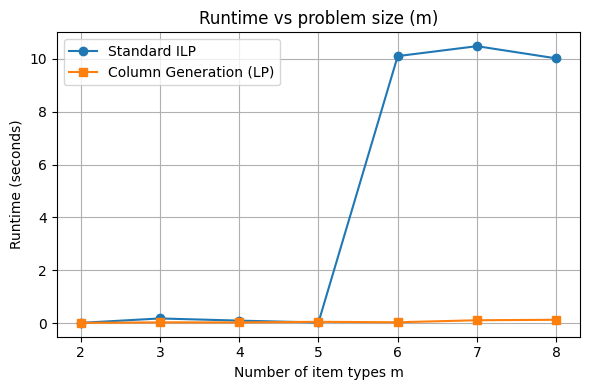

In [27]:
# %% [markdown]
# ## 6. Plot runtime vs number of item types

# %%
ms = [r["m"] for r in results]
times_ilp = [r["time_ilp"] for r in results]
times_cg = [r["time_cg"] for r in results]

plt.figure(figsize=(6, 4))
plt.plot(ms, times_ilp, marker="o", label="Standard ILP")
plt.plot(ms, times_cg, marker="s", label="Column Generation (LP)")

plt.xlabel("Number of item types m")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime vs problem size (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
